In [4]:
import pandas as pd
import numpy as np

# Load Rtab
rtab = pd.read_csv("gene_presence_absence.Rtab", sep="\t")

# Build binary presence/absence matrix
matrix = rtab.iloc[:, 1:]
matrix = (matrix > 0).astype(int)
matrix.index = rtab.iloc[:, 0]

n_genomes = matrix.shape[1]

print("Gene families:", matrix.shape[0])
print("Genomes:", matrix.shape[1])


Gene families: 6361
Genomes: 839


In [5]:
gene_counts = matrix.sum(axis=1)
gene_freq = gene_counts / n_genomes


In [6]:
structure_df = pd.DataFrame({
    "gene_id": matrix.index,
    "frequency": gene_freq.values
})

def assign_compartment(freq):
    if freq >= 0.99:
        return "Core"
    elif freq >= 0.95:
        return "Soft-core"
    elif freq >= 0.15:
        return "Shell"
    else:
        return "Cloud"

structure_df["compartment"] = structure_df["frequency"].apply(assign_compartment)

print(structure_df["compartment"].value_counts())


compartment
Cloud        3086
Core         1991
Shell        1205
Soft-core      79
Name: count, dtype: int64


In [7]:
eggnog = pd.read_csv("Galaxy41597-[eggNOG Mapper on dataset 41594_ annotations].tabular", sep="\t")

eggnog_clean = eggnog[["#query", "COG_category"]].copy()
eggnog_clean = eggnog_clean.rename(columns={"#query": "gene_id"})

eggnog_clean["COG_category"] = (
    eggnog_clean["COG_category"]
    .fillna("Unknown")
    .astype(str)
    .str[0]
)

eggnog_clean = eggnog_clean.drop_duplicates(subset="gene_id")

print("Annotated genes:", eggnog_clean.shape[0])


Annotated genes: 4927


In [27]:
def assign_compartment_v2(freq):
    if freq >= 0.95:
        return "Core"
    elif freq >= 0.15:
        return "Shell"
    else:
        return "Cloud"

structure_df["compartment_v2"] = structure_df["frequency"].apply(assign_compartment_v2)

print(structure_df["compartment_v2"].value_counts())


compartment_v2
Cloud    3086
Core     2070
Shell    1205
Name: count, dtype: int64


In [28]:
functional_df = structure_df.merge(
    eggnog_clean,
    on="gene_id",
    how="left"
)

functional_df["COG_category"] = (
    functional_df["COG_category"]
    .replace(["Unknown", "-"], "X")
    .fillna("X")
)


In [29]:
cog_compartment_table = pd.crosstab(
    functional_df["compartment_v2"],
    functional_df["COG_category"]
)

cog_compartment_prop = cog_compartment_table.div(
    cog_compartment_table.sum(axis=1),
    axis=0
)

cog_compartment_prop = cog_compartment_prop[sorted(cog_compartment_prop.columns)]


In [30]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(cog_compartment_table)

print("Chi-square p-value:", p)


Chi-square p-value: 0.0


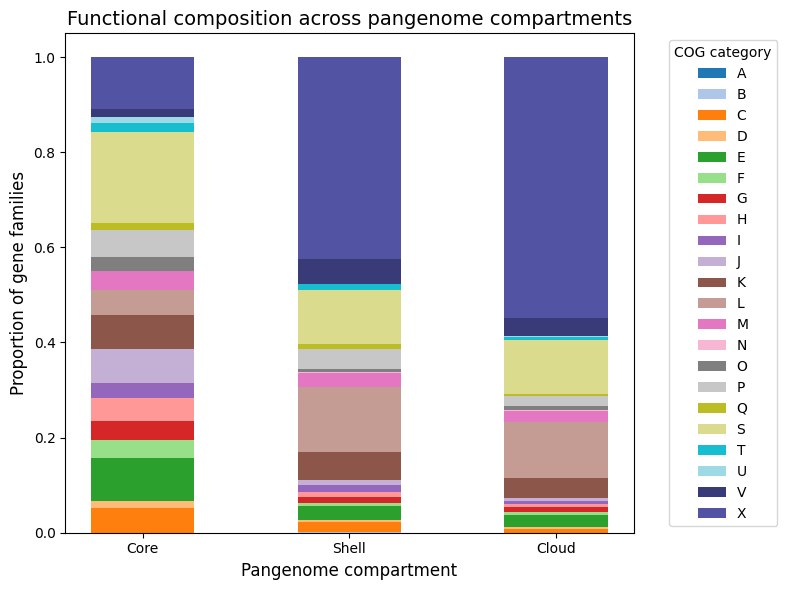

In [43]:
import matplotlib.pyplot as plt
import numpy as np

cog_categories = cog_compartment_prop.columns
from itertools import chain

cog_categories = cog_compartment_prop.columns

color_pool = list(chain(
    plt.cm.tab20.colors,
    plt.cm.tab20b.colors,
    plt.cm.tab20c.colors
))

colors = color_pool[:len(cog_categories)]


plt.figure(figsize=(8,6))

bottom = np.zeros(len(cog_compartment_prop))

for i, cog in enumerate(cog_categories):
    values = cog_compartment_prop[cog].values
    plt.bar(
        cog_compartment_prop.index,
        values,
        bottom=bottom,
        label=cog,
        color=colors[i],
        width=0.5
    )
    bottom += values

plt.ylabel("Proportion of gene families", fontsize=12)
plt.xlabel("Pangenome compartment", fontsize=12)
plt.title("Functional composition across pangenome compartments", fontsize=14)

plt.legend(
    title="COG category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    ncol=1,
    fontsize=10
)

plt.tight_layout()

plt.savefig("Figure_6_Functional_Composition_3comp.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_6_Functional_Composition_3comp.pdf",
            bbox_inches="tight")

plt.show()


In [44]:
# Sum proportions across compartments
total_abundance = cog_compartment_prop.sum(axis=0)

# Sort descending
total_abundance = total_abundance.sort_values(ascending=False)

print(total_abundance.head(15))


COG_category
X    1.080743
S    0.417577
L    0.306731
K    0.171737
E    0.144364
P    0.117953
V    0.108047
M    0.093144
J    0.088420
C    0.080050
H    0.065578
G    0.062295
I    0.051984
F    0.051602
O    0.045363
dtype: float64


In [46]:
top_n = 10
top_categories = list(total_abundance.head(top_n).index)

# Ensure X is included
if "X" not in top_categories:
    top_categories.append("X")

print("Keeping categories:", top_categories)


Keeping categories: ['X', 'S', 'L', 'K', 'E', 'P', 'V', 'M', 'J', 'C']


In [47]:
# Create new dataframe
simplified_prop = cog_compartment_prop.copy()

# Identify categories to collapse
categories_to_collapse = [
    c for c in simplified_prop.columns
    if c not in top_categories
]

# Sum them into "Other"
simplified_prop["Other"] = simplified_prop[categories_to_collapse].sum(axis=1)

# Keep only selected + Other
simplified_prop = simplified_prop[top_categories + ["Other"]]


In [48]:
simplified_prop = simplified_prop.loc[["Core", "Shell", "Cloud"]]


In [49]:
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

categories = simplified_prop.columns

color_pool = list(chain(
    plt.cm.tab20.colors,
    plt.cm.tab20b.colors,
    plt.cm.tab20c.colors
))

colors = color_pool[:len(categories)]


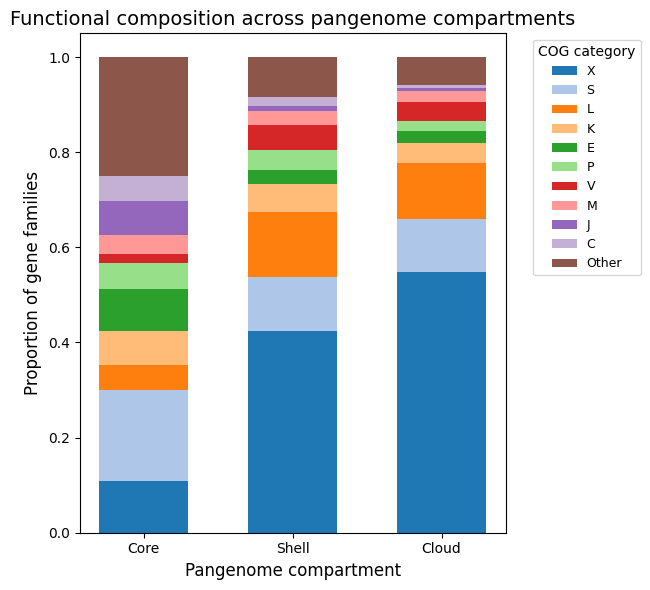

In [50]:
plt.figure(figsize=(6.5,6))

bottom = np.zeros(len(simplified_prop))

for i, cat in enumerate(categories):
    values = simplified_prop[cat].values
    plt.bar(
        simplified_prop.index,
        values,
        bottom=bottom,
        label=cat,
        color=colors[i],
        width=0.6
    )
    bottom += values

plt.ylabel("Proportion of gene families", fontsize=12)
plt.xlabel("Pangenome compartment", fontsize=12)
plt.title("Functional composition across pangenome compartments", fontsize=14)

plt.legend(
    title="COG category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)

plt.tight_layout()

plt.savefig("Figure_6_Functional_Composition_simplified.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_6_Functional_Composition_simplified.pdf",
            bbox_inches="tight")

plt.show()


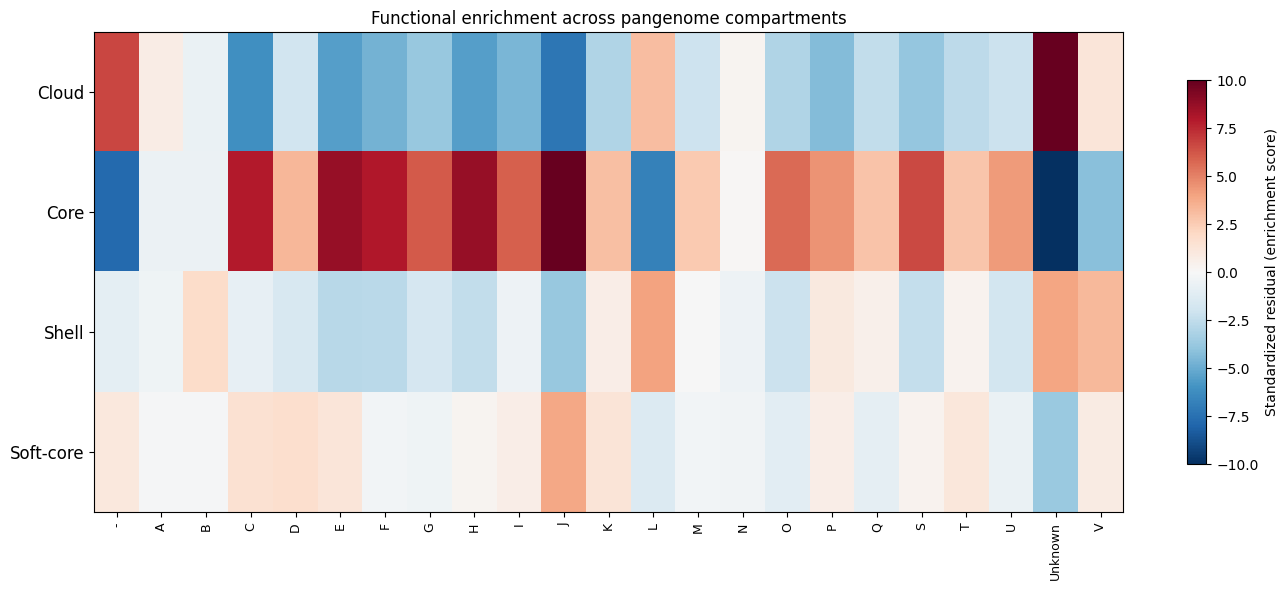

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.imshow(
    residuals,
    aspect="auto",
    cmap="RdBu_r",   # diverging
    vmin=-10,        # adjust depending on scale
    vmax=10
)

plt.xticks(
    ticks=range(len(residuals.columns)),
    labels=residuals.columns,
    rotation=90,
    fontsize=9
)

plt.yticks(
    ticks=range(len(residuals.index)),
    labels=residuals.index,
    fontsize=12
)

cbar = plt.colorbar(shrink=0.8)
cbar.set_label("Standardized residual (enrichment score)")

plt.title("Functional enrichment across pangenome compartments")

plt.tight_layout()

plt.savefig("Figure_6_Functional_Enrichment_residuals.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_6_Functional_Enrichment_residuals.pdf",
            bbox_inches="tight")

plt.show()


In [51]:
cog_compartment_table.to_csv(
    "Table_Functional_COG_counts_3comp.csv"
)


In [52]:
cog_compartment_prop.to_csv(
    "Table_Functional_COG_proportions_full.csv"
)


In [53]:
simplified_prop.to_csv(
    "Table_Functional_COG_proportions_simplified.csv"
)


In [54]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(cog_compartment_table)

with open("Table_Functional_ChiSquare_results.txt", "w") as f:
    f.write(f"Chi2: {chi2}\n")
    f.write(f"P-value: {p}\n")
    f.write(f"Degrees of freedom: {dof}\n")


In [55]:
expected_df = pd.DataFrame(
    expected,
    index=cog_compartment_table.index,
    columns=cog_compartment_table.columns
)

expected_df.to_csv(
    "Table_Functional_expected_counts.csv"
)

residuals.to_csv(
    "Table_Functional_standardized_residuals.csv"
)
